# Model Cars Company

# Index

- [1 Introduction](#1)
- [2 Reading the Data](#2)
- [3 And Your Question is..?](#3)
- [4 Supply and Profit](#4)
- [5 Customer Loyalty](#5)
- [6 Show Me the Money... By Country!!](#6)
- [7 Most Sought After..](#7)
- [8 Monthly Profits Performance...](#8)
- [9 Closing the Deal..](#9)
- [10 Put that Money to Work..](#10)
- [11 Deadstock](#11)
- [12 Recommendations](#12)
- [13 Conclusions](#13)
- [14 Learnings](#14)

# 1

## Introduction

![image](https://mycustomhotwheels.com/wp-content/uploads/2019/01/HIN-Hot-Wheels-Diorama-15-1080x675.jpg)
*Source*:[mycustomhotwheels](https://mycustomhotwheels.com/hotwheels-at-hin2018/)

Vehicle Models Company is a fictitious wholesale distributor of die cast models of vehicles ranging from vintage cars to planes. They have customers in more than 15 countries around the world. 

The company has asked us to go over their dataset and analyse the same to make some essential decisions related to potential future expansion.

The goal of this project is to go over the questions that they have and extract answers based on the data.

It must be noted that the organization has given us freedom in taking assumptions as they do not have staff that can cater to our doubts and questions. We have been advised that clarification (regarding our assumptions) will be made after an initial report has been submitted.

# 2

## Reading the Data

The required data is available [here](https://www.mysqltutorial.org/mysql-sample-database.aspx) along with the schema which has been provided below.

In [1]:
%%capture
%load_ext sql
%sql sqlite:///stores.db

![image](https://www.mysqltutorial.org/wp-content/uploads/2009/12/MySQL-Sample-Database-Schema.png)

Before we proceed with analysing the database, let's look at an overview of it.

In [2]:
%%sql
SELECT '' AS Table_Names,'' AS Number_of_Attributes,'' AS Number_of_Rows
UNION ALL
SELECT 'Customer',13,(SELECT COUNT(*)
                        FROM customers)
UNION ALL
SELECT 'Products',9,(SELECT COUNT(*)
                        FROM products)
UNION ALL
SELECT 'ProductLines',4,(SELECT COUNT(*)
                        FROM productlines)
UNION ALL
SELECT 'Orders',7,(SELECT COUNT(*)
                        FROM orders)
UNION ALL
SELECT 'OrderDetails',5,(SELECT COUNT(*)
                        FROM orderdetails)
UNION ALL
SELECT 'Payments',4,(SELECT COUNT(*)
                        FROM payments)
UNION ALL
SELECT 'Employees',8,(SELECT COUNT(*)
                        FROM employees)
UNION ALL
SELECT 'Offices',9,(SELECT COUNT(*)
                        FROM offices)

 * sqlite:///stores.db
Done.


Table_Names,Number_of_Attributes,Number_of_Rows
,,
Customer,13,122
Products,9,110
ProductLines,4,7
Orders,7,326
OrderDetails,5,2996
Payments,4,273
Employees,8,23
Offices,9,7


Also, let's look at a description of each table:

- Customers: stores customer’s data.
- Products: stores a list of scale model cars.
- ProductLines: stores a list of product line categories.
- Orders: stores sales orders placed by customers.
- OrderDetails: stores sales order line items for each sales order.
- Payments: stores payments made by customers based on their accounts.
- Employees: stores all employee information as well as the organization structure such as who reports to whom.
- Offices: stores sales office data.

Now, let's turn to the offices table. We are going to read the following SQL query into a DataFrame.

In [3]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

conn = sqlite3.connect('stores.db')
df = pd.read_sql_query("""SELECT * 
                            FROM offices;""", conn)
df

,officeCode,city,phone,addressLine1,addressLine2,state,country,postalCode,territory
0,1,San Francisco,+1 650 219 4782,100 Market Street,Suite 300,CA,USA,94080,NA
1,2,Boston,+1 215 837 0825,1550 Court Place,Suite 102,MA,USA,02107,NA
2,3,NYC,+1 212 555 3000,523 East 53rd Street,apt. 5A,NY,USA,10022,NA
3,4,Paris,+33 14 723 4404,43 Rue Jouffroy D'abbans,None,None,France,75017,EMEA
4,5,Tokyo,+81 33 224 5000,4-1 Kioicho,None,Chiyoda-Ku,Japan,102-8578,Japan
5,6,Sydney,+61 2 9264 2451,5-11 Wentworth Avenue,Floor #2,None,Australia,NSW 2010,APAC
6,7,London,+44 20 7877 2041,25 Old Broad Street,Level 7,None,UK,EC2N 1HN,EMEA


The company has a number of offices and each office has multiple employees. Every customer is associated to a sales rep. whose employee ID is recorded in the salesRepEmployeeNumber column of the Customer table.

The company has many products that are categorised into product lines. Every incoming order lists certain order specific details related to a product and those details are listed in the OrderDetails table. The orders associated to the items in the OrderDetails table are separately tracked in the Orders table. 

The status column in the order tracks the progress of the order from when it is received to when it is shipped out. The different statuses of an order have been listed below.

Once the order is shipped out, customers seem to be paying for their orders in a cumulative manner. Customers have the option of utilising credit based on the CreditLimit column the in the Customer table. While going over the comments column of the Orders table it was noticed that an order can be put on hold if a user has gone beyond their credit limit for a particular order. The order is processed only after the payment is cleared.

In [4]:
%%sql
SELECT status AS Order_Status,COUNT(status) AS Number_of_Orders
  FROM orders
 GROUP BY status
 ORDER BY Number_of_Orders DESC

 * sqlite:///stores.db
Done.


Order_Status,Number_of_Orders
Shipped,303
In Process,6
Cancelled,6
Resolved,4
On Hold,4
Disputed,3


We shall be analyzing only orders that have shipped out since all of the other orders require payment clearance. Orders and Order Details associated to shipped orders will therefore need to be filtered out.

In [6]:
%%sql
--#Create view to filter only orders with status 'Shipped'
CREATE VIEW shipped_orders AS
SELECT orders.*,
       ROUND(SUM(orderdetails.quantityOrdered*orderdetails.priceEach),2) AS Order_Total,
       ROUND(SUM((orderdetails.priceEach - products.buyPrice)*orderdetails.quantityOrdered),2) AS Order_Profit
  FROM orders
  JOIN orderdetails
    ON orders.orderNumber=orderdetails.orderNumber
  JOIN products
    ON orderdetails.productCode=products.productCode
 GROUP BY orders.orderNumber
HAVING status = 'Shipped';

SELECT *
  FROM shipped_orders
 LIMIT 5;

 * sqlite:///stores.db
Done.
Done.


orderNumber,orderDate,requiredDate,shippedDate,status,comments,customerNumber,Order_Total,Order_Profit
10100,2003-01-06,2003-01-13,2003-01-10,Shipped,None,363,10223.83,3940.36
10101,2003-01-09,2003-01-18,2003-01-11,Shipped,Check on availability.,128,10549.01,5236.74
10102,2003-01-10,2003-01-18,2003-01-14,Shipped,None,181,5494.78,2135.94
10103,2003-01-29,2003-02-07,2003-02-02,Shipped,None,121,50218.95,18827.11
10104,2003-01-31,2003-02-09,2003-02-01,Shipped,None,141,40206.2,15680.8


In [7]:
%%sql
--#Filter Order details associated to orders with 'Shipped' status
CREATE VIEW shipped_order_details AS
SELECT *
  FROM orderdetails
 WHERE orderNumber IN (SELECT orderNumber
                         FROM shipped_orders);

 * sqlite:///stores.db
Done.


[]

Now that we have filtered the order and order details based on the order status, we can explore the questions that Vehicles Models Company has.

# 3

## And Your Question is..?
**Exploring the questions put forward by Vehicles Models Company**

We have been asked to make assessments or answer related to the following:

1. Can you identify the top 10 models that are in demand?
2. Identify for us, the top five customers
3. In which countries should we target our marketing for maximum return?
4. Identify the best and worst categories for each country
5. How was the sales performance over the entire time period when we have had sales?
6. We want to expand our sales team, however we need to know the performance of our current sales team.
7. Should we focus on getting new customers or engaging our existing customers to increase our sales?
8. Are there items in our stock that have not sold for a long time?

Clearly some of these questions are not very precise and require a number of assumptions. As mentioned earlier we shall make the assessments and answer these questions using assumptions.

# 4

## Supply and Profit
**Identifying Products that are in high demand and have great selling value**

Our first question pertains to identifying items that are in high demand in most orders and highly profitable to us. Stocking up on these items will ensure that we can fulfil the market needs and simultaneously make some extra cash.

The customer has provided formulas by which we are expected to identify items that are currently in low stock and to identify items that exhibit great selling power.

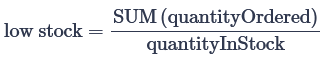

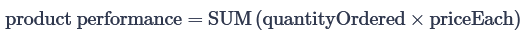